# Post processing and visualization

![](heat_square_fluxes.png)

*Figure 1*: Heat flux computed from the solution to the heat equation on
the unit square, see previous example: Heat equation.

## Introduction

After running a simulation, we usually want to visualize the results in different ways.
The `L2Projector` and the `PointEvalHandler` build a pipeline for doing so. With the `L2Projector`,
integration point quantities can be projected to the nodes. The `PointEvalHandler` enables evaluation of
the finite element approximated function in any coordinate in the domain. Thus with the combination of both functionalities,
both nodal quantities and integration point quantities can be evaluated in any coordinate, allowing for example
cut-planes through 3D structures or cut-lines through 2D-structures.

This example continues from the Heat equation example, where the temperature field was
determined on a square domain. In this example, we first compute the heat flux in each
integration point (based on the solved temperature field) and then we do an L2-projection
of the fluxes to the nodes of the mesh. By doing this, we can more easily visualize
integration points quantities. Finally, we visualize the temperature field and the heat fluxes along a cut-line.

The L2-projection is defined as follows: Find projection $q(\boldsymbol{x}) \in U_h(\Omega)$ such that
$$
\int v q \ \mathrm{d}\Omega = \int v d \ \mathrm{d}\Omega \quad \forall v \in U_h(\Omega),
$$
where $d$ is the quadrature data to project. Since the flux is a vector the projection function
will be solved with multiple right hand sides, e.g. with $d = q_x$ and $d = q_y$ for this 2D problem.
In this example, we use standard Lagrange interpolations, and the finite element space $U_h$ is then
a subset of the $H^1$ space (continuous functions).

Ferrite has functionality for doing much of this automatically, as displayed in the code below.
In particular `L2Projector` for assembling the left hand side, and
`project` for assembling the right hand sides and solving for the projection.

## Implementation

Start by simply running the Heat equation example to solve the problem

In [1]:
include("../tutorials/heat_equation.jl");

Next we define a function that computes the heat flux for each integration point in the domain.
Fourier's law is adopted, where the conductivity tensor is assumed to be isotropic with unit
conductivity $\lambda = 1 ⇒ q = - \nabla u$, where $u$ is the temperature.

In [2]:
function compute_heat_fluxes(cellvalues::CellValues, dh::DofHandler, a::AbstractVector{T}) where T

    n = getnbasefunctions(cellvalues)
    cell_dofs = zeros(Int, n)
    nqp = getnquadpoints(cellvalues)

    # Allocate storage for the fluxes to store
    q = [Vec{2,T}[] for _ in 1:getncells(dh.grid)]

    for (cell_num, cell) in enumerate(CellIterator(dh))
        q_cell = q[cell_num]
        celldofs!(cell_dofs, dh, cell_num)
        aᵉ = a[cell_dofs]
        reinit!(cellvalues, cell)

        for q_point in 1:nqp
            q_qp = - function_gradient(cellvalues, q_point, aᵉ)
            push!(q_cell, q_qp)
        end
    end
    return q
end

compute_heat_fluxes (generic function with 1 method)

Now call the function to get all the fluxes.

In [3]:
q_gp = compute_heat_fluxes(cellvalues, dh, u);

Next, create an `L2Projector` using the same interpolation as was used to approximate the
temperature field. On instantiation, the projector assembles the coefficient matrix `M` and
computes the Cholesky factorization of it. By doing so, the projector can be reused without
having to invert `M` every time.

In [4]:
projector = L2Projector(ip, grid);

Project the integration point values to the nodal values

In [5]:
q_projected = project(projector, q_gp, qr);

## Exporting to VTK
To visualize the heat flux, we export the projected field `q_projected`
to a VTK-file, which can be viewed in e.g. [ParaView](https://www.paraview.org/).
The result is also visualized in *Figure 1*.

In [6]:
VTKGridFile("heat_equation_flux", grid) do vtk
    write_projection(vtk, projector, q_projected, "q")
end;

## Point evaluation
![](heat_square_pointevaluation.png)

*Figure 2*: Visualization of the cut line where we want to compute
the temperature and heat flux.

Consider a cut-line through the domain like the black line in *Figure 2* above.
We will evaluate the temperature and the heat flux distribution along a horizontal line.

In [7]:
points = [Vec((x, 0.75)) for x in range(-1.0, 1.0, length=101)];

First, we need to generate a `PointEvalHandler`. This will find and store the cells
containing the input points.

In [8]:
ph = PointEvalHandler(grid, points);

After the L2-Projection, the heat fluxes `q_projected` are stored in the DoF-ordering
determined by the projector's internal DoFHandler, so to evaluate the flux `q` at our points
we give the `PointEvalHandler`, the `L2Projector` and the values `q_projected`.

In [9]:
q_points = evaluate_at_points(ph, projector, q_projected);

We can also extract the field values, here the temperature, right away from the result
vector of the simulation, that is stored in `u`. These values are stored in the order of
our initial DofHandler so the input is not the `PointEvalHandler`, the original `DofHandler`,
the dof-vector `u`, and (optionally for single-field problems) the name of the field.
From the `L2Projection`, the values are stored in the order of the degrees of freedom.

In [10]:
u_points = evaluate_at_points(ph, dh, u, :u);

Now, we can plot the temperature and flux values with the help of any plotting library, e.g. Plots.jl.
To do this, we need to import the package:

In [11]:
import Plots

Firstly, we are going to plot the temperature values along the given line.

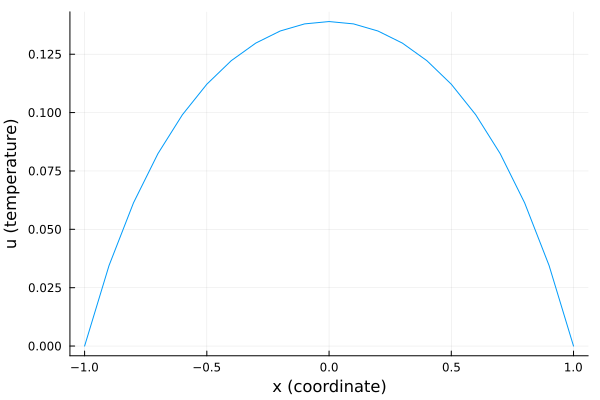

In [12]:
Plots.plot(getindex.(points,1), u_points, xlabel="x (coordinate)", ylabel="u (temperature)", label=nothing)

*Figure 3*: Temperature along the cut line from *Figure 2*.

Secondly, the horizontal heat flux (i.e. the first component of the heat flux vector) is plotted.

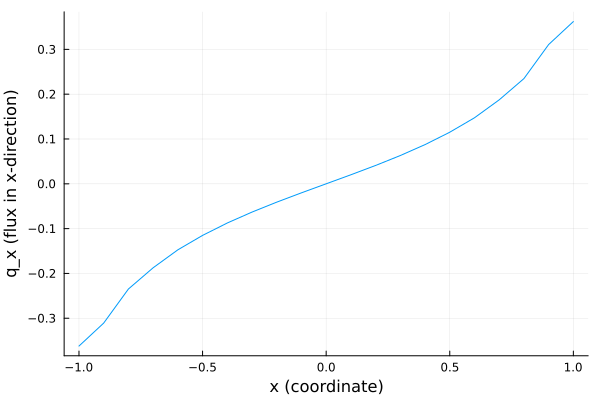

In [13]:
Plots.plot(getindex.(points,1), getindex.(q_points,1), xlabel="x (coordinate)", ylabel="q_x (flux in x-direction)", label=nothing)

*Figure 4*: $x$-component of the flux along the cut line from *Figure 2*.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*